# Electric supersonic VTOL jet exploration

The goal of this notebook is to explore a supersonic VTOL electric jet. By building a drag model and using different assumptions, we can explore what such an airplane might look like, and analyze what its range would be given different batteries and wing layouts. See [Elon Musk's thoughts](https://www.youtube.com/watch?v=RyS92KPQnjk) on electric jets.

### Aircraft layout

The aircraft could either be a conventional design (with a separate fuselage and wing) or a [blended wing body](https://en.wikipedia.org/wiki/Blended_wing_body). There would be many fans embedded in the wing that can be used for VTOL. A tail is not needed; the combination of swept wing tips and distributed propulsion would provide adequate control. The fuselage length is set equal to the "total" chord of the wing (from root leading edge to wingtip trailing edge).

### VTOL

Many small motors and fans could be used to provide improved reliability ([distributed propulsion](https://en.wikipedia.org/wiki/Distributed_propulsion)). Distributed electric propulsion enables VTOL, which eliminates the need for extremely large airport runways.

During takeoff and landing, electric motors can run for short periods of time at a higher than nominal power. This would reduce the mass requirement of the motors required for VTOL. The primary engines, if they were able to gimbal, would also contribute vertical lift.

### Flight engines

The propulsion is assumed to be, effectively, electric compressors connected to a nozzle. Air is decelerated in an inlet which raises the pressure. A multi-stage axial compressor further raises the pressure, and the air is accelerated out of a nozzle (converging nozzle for subsonic flow, or converging-diverging nozzle for supersonic flow). The engines would be positioned along the trailing edge of the wing.

Like the VTOL system, many smaller engines can be used to provide improved reliability. [Boundary layer ingestion](https://en.wikipedia.org/wiki/Boundary_layer#Boundary_layer_ingestion) may be feasible if many smaller engines (with smaller compressor diameters) are embedded in the trailing edge of the aircraft.


## Model

We build a drag model in this notebook that allows us to compute the drag of an aircraft with different paramters (wing area, aspect ratio, lift requirement, and so on). The drag model is based on the [incredible work of the late R.T. Jones](https://ntrs.nasa.gov/archive/nasa/casi.ntrs.nasa.gov/19760011971.pdf).

The aircraft structural model is very simple: we simply assume a fixed mass of the aircraft (80% in this case) is used for batteries. 80% may seem high, but rockets often have a [propellant mass fraction](https://en.wikipedia.org/wiki/Propellant_mass_fraction) greater than 80%! Batteries allow us to do this more easily than fuel because batteries have a much higher density (2.5x) than rocket fuel, so the constraint would mostly be mass instead of volume.

The propulsion model is also very simple: we assume that the main engines have a total efficiency of 72% and the VTOL fans have a total efficiency of 1%. While the VTOL efficiency may seem very low, remember that this is the total efficiency of converting the electrical energy in the batteries to gravitational potential energy. The majority of the energy is used for hovering and only a small proportion is used for movement.

There are four stages of flight in the model: ascent, cruise, descent, and reserve. The reserve stage does not contribute to the total flight distance as it should only be used in emergencies.

### Optimization

Different parameters can be fed into the model to generate different aircraft performance. Here are all the parameters (SI units are used): battery_mass, wing_area, sweep_angle, climb_duration, climb_power, climb_airspeed, cruise_duration, cruise_power, descent_duration, descent_power, descent_airspeed, reserve_power, reserve_airspeed, battery_specific_energy, cruise_airspeed, and aspect_ratio.

All of these parameters are allowed to vary within the optimization except for [battery specific energy](https://en.wikipedia.org/wiki/Specific_energy), [cruise airspeed](https://en.wikipedia.org/wiki/True_airspeed), and [aspect ratio](https://en.wikipedia.org/wiki/Aspect_ratio_(aeronautics)), which are fixed. Using various values for these fixed parameters, we can optimize the remaining parameters to find the optimal aircraft at different fixed parameter values.

Differential evolution (from [scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.differential_evolution.html)) is used as the optimization technique to maximize aircraft range over the floating variables.

After optimizing different aircraft, we regress the range versus battery specific energy for different aspect ratios and airspeeds. This lets us see the required battery specific energy needed to achieve a given range at different aspect ratios and airspeeds. Since battery specific energy is projected to grow around 5-10% per year, we could use this to predict when a VTOL electric jet (both subsonic and supersonic) will be viable.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numba import jit
from scipy import optimize, interpolate
from labellines import labelLines

pd.set_option('max_columns', 99)
%matplotlib inline

In [2]:
R = 8314.46 # J/(kmol*K)
gamma = 1.40 # air
M = 28.895 # kg/kmol, air
gravitational_constant = 6.674e-11
earth_mass = 5.972e24 # kg
earth_radius = 6375000 # m
atm_data = pd.read_csv('st_atm_1976.csv', index_col='Altitude [m]').values

In [3]:
@jit
def atmosphere(altitude):
    # Returns temp, pressure, density, speed of sound, and dynamic viscosity
    altitude = max(0, altitude)
    altitude = min(altitude, 50000)
    return atm_data[int(round(altitude, -2) / 100)]

T_ground, P_ground, rho_ground, c_ground, u_ground = atmosphere(0)


@jit
def swept_wing(Cl, wing_area, aspect_ratio, sweep_angle, Ma):

    """
    Compute the coefficient of drag of the given wing.
    Induced drag is derived from "Three-dimensional wings of minimum pressure drag" by
    Robert T. Jones. This material can be found at
    https://ntrs.nasa.gov/archive/nasa/casi.ntrs.nasa.gov/19760011971.pdf page 661
    The wing is treated as a yawed ellipse. See diagram in paper for variables.
    """

    psi = np.pi / 2 - sweep_angle
    a_prime = 2 * np.sqrt(wing_area) / (np.pi * np.sqrt(aspect_ratio))
    b_prime = np.sqrt(wing_area * aspect_ratio) / 2

    # Solve for b given a', b', and angle of yaw
    # http://bit.ly/2lY0T04, 4th solution
    if b_prime**2 - 4 * a_prime**2 * np.sin(psi)**2 * np.cos(psi)**2 > 0:
        within = b_prime ** 2 + np.sqrt(b_prime ** 2 * (b_prime**2 - 4 * a_prime**2 * np.sin(psi)**2 * np.cos(psi)**2))
        b = np.sqrt((1 / np.sin(psi))**2 * within) / np.sqrt(2)
    else:
        return 1e50, 1, 1, 1

    a = a_prime * b_prime / b
    wingspan = b_prime * 2 * np.sin(psi)

    # Subsonic induced drag
    # http://www.fzt.haw-hamburg.de/pers/Scholz/OPerA/OPerA_PUB_DLRK_12-09-10.pdf
    if sweep_angle > np.pi / 6: # > 30 degrees, swept wing (Raymer)
        e = 4.61 * (1 - 0.045 * aspect_ratio ** 0.68) * np.cos(sweep_angle) ** 0.15 - 3.1
    else: # Unswept wing (Raymer)
        e = 1.78 * (1 - 0.045 * aspect_ratio ** 0.68) - 0.64
    if e < 0:
        return 1e50, 1, 1, 1

    Cd_Cl2 = 1 / (np.pi * e * aspect_ratio)
    
    # Karman-Tsien compressibility correction
    beta = np.sqrt(np.abs(1 - Ma ** 2))
    Cd_Cl2 = Cd_Cl2 / (beta + Ma ** 2 / (1 + beta) * Cd_Cl2 / 2)

    # Supersonic pressure drag
    if Ma > 1:
        m = (b ** 2 - a ** 2) * np.sin(psi) * np.cos(psi) / b_prime ** 2

        # There is a mistake in Jones' formula, a and b should be primed
        Cd_Cl2 += 1 / 4 * np.sqrt(Ma ** 2 - 1 - (m + 1j * a_prime / b_prime) ** 2).real

    Cd = Cd_Cl2 * Cl ** 2

    min_wing_dimension = min(a, b)

    # The *total* aircraft length from nose to trailing edge
    aircraft_length = b_prime * np.cos(psi) + a_prime / np.cos(sweep_angle)

    return Cd, min_wing_dimension, aircraft_length, wingspan


@jit
def compute_drag(rho=0, v=0, c=0, L=0, dynamic_viscosity=0, T=0,
                 wing_area=0, sweep_angle=0, aspect_ratio=0, fuselage_diameter=2.0):
    """
    Compute drag on a subsonic or supersonic plane. We assume here that the
    fuselage length is equal to the wing root chord, which creates the blended
    wing body.
    """

    Ma = v / c # Mach number

    ## Lift induced drag
    Cl = 2 * L / (wing_area * rho * v ** 2) # Calculate required Cl
    Cd, min_wing_dimension, aircraft_length, wingspan = swept_wing(Cl, wing_area, aspect_ratio, sweep_angle, Ma)
    induced_drag = 0.5 * Cd * wing_area * rho * v ** 2
    
    ## Profile wave drag
    if Ma > 1:
        Cd_wave = 9 / 2 * np.pi ** 2 * (fuselage_diameter / aircraft_length) ** 2 # Sears-Haack body
        Cd_wave *= 1.05 # Sears-Haack imperfection scaling
        wave_drag_profile = Cd_wave * np.pi * fuselage_diameter ** 2 * 0.5 * rho * v ** 2
    else:
        wave_drag_profile = 0

    ## Skin friction drag
    # http://mail.tku.edu.tw/095980/drag.pdf
    # Assume boundary layer is turbulent, which also leads to pressure drag being negligible
    Re = v * aircraft_length * rho / dynamic_viscosity
    Twall = T * (1 + 0.178 * Ma**2)
    Tprime = T * (1 + 0.035 * Ma**2 + 0.45 * (Twall / T - 1))
    Reprime = Re * (((T + 120) / (Tprime + 120)) * (T / Tprime) ** 1.5)
    Cfprime = 0.455 / np.log10(Reprime) ** 2.58
    Cfprime = Cfprime * 1.05 # Roughness and gap scaling
    Cf = T / Tprime * Cfprime

    # The fuseslage length is equal to the aircraft_length
    S_body = 16 / 5 * 0.25349 * aircraft_length * fuselage_diameter * np.pi ** (3 / 2) # http://bit.ly/2gugQof
    S_wing = (wing_area - fuselage_diameter * aircraft_length) * 2
    S_total = S_body + S_wing

    parasitic_drag = 0.5 * Cf * S_total * rho * v**2

    total_drag = wave_drag_profile + induced_drag + parasitic_drag

    return total_drag, aircraft_length, wingspan


### Drag test

Show sample drag based off of our drag model. We should expect a spike around Mach 1, where drag is highest.

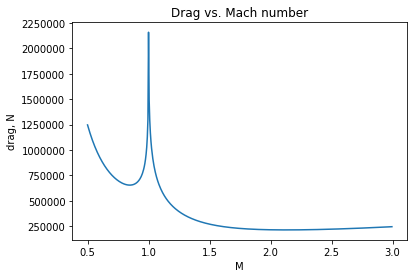

In [4]:
Ma = np.arange(100, 600) / 200
dr = []
for i in Ma:
    v = i * 295.07
    d = compute_drag(rho=0.1151, v=v, c=295.07, L=1.5e6, dynamic_viscosity=0.000014,
                     T=216.65, wing_area=418.25,
                     sweep_angle=np.pi/3, aspect_ratio=1.55)[0]
    dr.append(d)

plt.plot(Ma, dr)
plt.title('Drag vs. Mach number')
plt.xlabel('M')
plt.ylabel('drag, N');

# Model settings

In [5]:
battery_cell_mass_fraction = 0.8 # 80% of the aircraft in mass is batteries
vtol_wingfan_efficiency = 0.01 # Efficiency is extremely low, because most energy is used for hover
engine_efficiency = 0.72 # ~85% propulsive efficiency * ~85% compressor efficiency = ~72% efficiency

battery_usage_fraction = 0.92 # Only use 92% of battery to improve cycle life
vtol_altitude = 50.0 # VTOL gets us up to 50 meters

# As defined by https://www.law.cornell.edu/cfr/text/14/121.645
# We use 45 instead of 30 b/c flight to alternate airport ~= 15 mins
reserve_duration = 45 * 60 # seconds of holding for compliance (30 minutes reserve + 15 minutes for diversion)
reserve_altitude = 450 # m, holding altitude

# Require a certain cruising altitude; flying too low causes too much noise from sonic booms
min_cruising_altitude = 15000

dt = 30.0 # seconds

bounds = {
    'battery_mass': (1, 100000),
    'wing_area': (1, 400),
    'sweep_angle': (0.001, np.pi/2 * 0.99),
    'climb_duration': (5 * 60, 20 * 60),
    'climb_power': (1, 10e8),
    'climb_airspeed': (50, 500),
    'cruise_duration': (1 * 60, 600 * 60),
    'cruise_power': (1, 10e8),
    'descent_duration': (5 * 60, 20 * 60),
    'descent_power': (1, 10e8),
    'descent_airspeed': (50, 500),
    'reserve_power': (1, 10e8),
    'reserve_airspeed': (10, 300),
}

# Given a plane, output the performance of that plane

In [6]:
@jit
def compute_flight(battery_mass, wing_area, sweep_angle,
                   climb_duration, climb_power, climb_airspeed,
                   cruise_duration, cruise_power,
                   descent_duration, descent_power, descent_airspeed,
                   reserve_power, reserve_airspeed,
                   battery_specific_energy, cruise_airspeed, aspect_ratio):

    total_mass = battery_mass / battery_cell_mass_fraction # kg
    max_battery_energy = battery_mass * battery_specific_energy * 3600 * battery_usage_fraction # J

    # VTOL energy
    vtol_takeoff_energy = total_mass * 9.81 * vtol_altitude * vtol_wingfan_efficiency
    vtol_landing_energy = total_mass * 9.81 * vtol_altitude * vtol_wingfan_efficiency

    # Number of time steps
    nt = int((climb_duration + cruise_duration + descent_duration + reserve_duration) / dt)

    # Initialize variables
    t = 0
    battery_starting_energy = max_battery_energy - vtol_takeoff_energy - vtol_landing_energy
    battery_energy = battery_starting_energy
    altitude = vtol_altitude
    distance = 0.0
    prev_kinetic_energy = 0.0
    cruise_ending_distance = 0.0
    climb_ending_distance = 0.0
    cruise_ending_distance = 0.0
    climb_ending_distance = 0.0
    altitude_store = np.empty(nt)

    # Iterate over each time step
    for i in range(nt):
        t += dt

        if t < climb_duration:
            engine_power_t = climb_power
            true_airspeed_t = climb_airspeed
            climb_ending_distance = distance
            climb_ending_altitude = altitude
        elif t < (climb_duration + cruise_duration):
            engine_power_t = cruise_power
            true_airspeed_t = cruise_airspeed
            cruise_ending_distance = distance
            cruise_ending_altitude = altitude
        elif t < (climb_duration + cruise_duration + descent_duration):
            engine_power_t = descent_power
            true_airspeed_t = descent_airspeed
            descent_ending_distance = distance
            descent_ending_altitude = altitude
        elif t < (climb_duration + cruise_duration + descent_duration + reserve_duration):
            engine_power_t = reserve_power
            true_airspeed_t = reserve_airspeed

        T, P, rho, c, u = atmosphere(altitude)

        # Thrust is simply defined by mechanical work and efficiency
        thrust_t = engine_power_t * engine_efficiency / true_airspeed_t

        # There is a slight outward acceleration due to centrifugal force (like a satellite)
        lift_t = total_mass * gravitational_constant * earth_mass / (earth_radius + altitude) ** 2
        lift_t -= total_mass * true_airspeed_t ** 2 / (earth_radius + altitude)

        drag_t, aircraft_length, wingspan = compute_drag(rho=rho, v=true_airspeed_t, c=c, L=lift_t,
                                                         dynamic_viscosity=u, T=T, wing_area=wing_area,
                                                         sweep_angle=sweep_angle, aspect_ratio=aspect_ratio)

        # Compute the change in altitude of the airplane in the current time step
        # https://en.wikipedia.org/wiki/Lift-to-drag_ratio
        # Get the climb angle from the free body diagram of a climbing plane 
        # drag * cos(theta) + lift * sin(theta) = thrust * cos(theta), solve for theta, then get vertical speed
        angle_of_climb = np.arctan((thrust_t - drag_t) / lift_t)
        vertical_airspeed = true_airspeed_t * np.sin(angle_of_climb) # Vertical true airspeed
        altitude_delta = vertical_airspeed * dt

        battery_energy -= engine_power_t * dt

        # Account for extra power delta of acceleration/deceleration
        kinetic_energy = 0.5 * total_mass * true_airspeed_t ** 2
        battery_energy -= (kinetic_energy - prev_kinetic_energy) / engine_efficiency
        prev_kinetic_energy = kinetic_energy

        altitude += altitude_delta
        distance += true_airspeed_t * np.cos(angle_of_climb) * dt

        altitude_store[i] = altitude
        
        engine_power_t = None
        true_airspeed_t = None

    # All of these objectives have to be met for the aircraft to be valid
    objectives = np.array([
        descent_ending_altitude / vtol_altitude - 1, # Descent ending altitude > starting altitude
        min(altitude_store) / vtol_altitude - 1, # Min altitude > starting altitude
        battery_energy / max_battery_energy,
        climb_ending_altitude / min_cruising_altitude - 1,
        cruise_ending_altitude / min_cruising_altitude - 1,
        altitude / reserve_altitude - 1, # Reserve end altitude > required reserve altitude
    ])

    # If all of the objectives are met, then the loss is given as a function of the range
    # If the objectives are not met, then our loss is based on the objectives
    if np.all(objectives >= 0):
        loss = -1 * np.power(descent_ending_distance, 2)
    else:
        loss = np.sqrt(np.array([np.abs(min(x, 0)) ** 2 for x in objectives]).sum())

    # Return interesting outputs
    result = {
        'descent_end_altitude_rel': objectives[0],
        'min_altitude_rel': objectives[1],
        'battery_energy_remaining': objectives[2],
        'reserve_altitude_rel': objectives[5],
        'flight_energy_frac': battery_starting_energy / max_battery_energy,
        'aircraft_length': aircraft_length,
        'wingspan': wingspan,
        'climb_ending_distance': climb_ending_distance,
        'cruise_ending_distance': cruise_ending_distance,
        'total_distance': descent_ending_distance,
        'reserve_ending_distance': distance,
        'climb_ending_altitude': climb_ending_altitude,
        'cruise_ending_altitude': cruise_ending_altitude,
        'descent_ending_altitude': descent_ending_altitude,
        'reserve_ending_altitude': altitude,
        'loss': loss,
    }

    return result


def compute_flight_opt(x, *args):
    # Wrapper function for optimization
    return compute_flight(*x, *args)['loss']

# Optimize plane for range

The plane is optimized at different airspeed, aspect ratio, and battery specific energy combinations. We can then interpolate range versus battery specific energy at different airspeeds and aspect ratios to generate plots of range vs. battery specific energy.

In [7]:
specific_energies = [200, 400, 600, 800, 1000, 1300, 1600, 2000]

configurations = [
    {'cruise_airspeed': 250, 'aspect_ratio': 12.0, 'battery_specific_energy': specific_energies},
    {'cruise_airspeed': 250, 'aspect_ratio': 6.0, 'battery_specific_energy': specific_energies},
    {'cruise_airspeed': 250, 'aspect_ratio': 2.0, 'battery_specific_energy': specific_energies},
    {'cruise_airspeed': 700, 'aspect_ratio': 6.0, 'battery_specific_energy': specific_energies},
    {'cruise_airspeed': 700, 'aspect_ratio': 2.0, 'battery_specific_energy': specific_energies},
    {'cruise_airspeed': 700, 'aspect_ratio': 12.0, 'battery_specific_energy': specific_energies},
]

plane_samples = {}

for configuration in configurations:
    cruise_airspeed = configuration['cruise_airspeed']
    aspect_ratio = configuration['aspect_ratio']

    for battery_specific_energy in configuration['battery_specific_energy']:
        args = (battery_specific_energy, cruise_airspeed, aspect_ratio)

        o = optimize.differential_evolution(compute_flight_opt, popsize=200, strategy='randtobest1bin',
                                            maxiter=5000, tol=0.00001, bounds=[bounds[b] for b in bounds.keys()],
                                            args=args, init='random', updating='deferred', workers=2)

        plane_samples[args] = compute_flight(*o.x, *args)
        plane_samples[args].update(dict(zip(bounds.keys(), o.x)))

Plot range vs. battery specific energy at different airspeeds and aspect ratios:

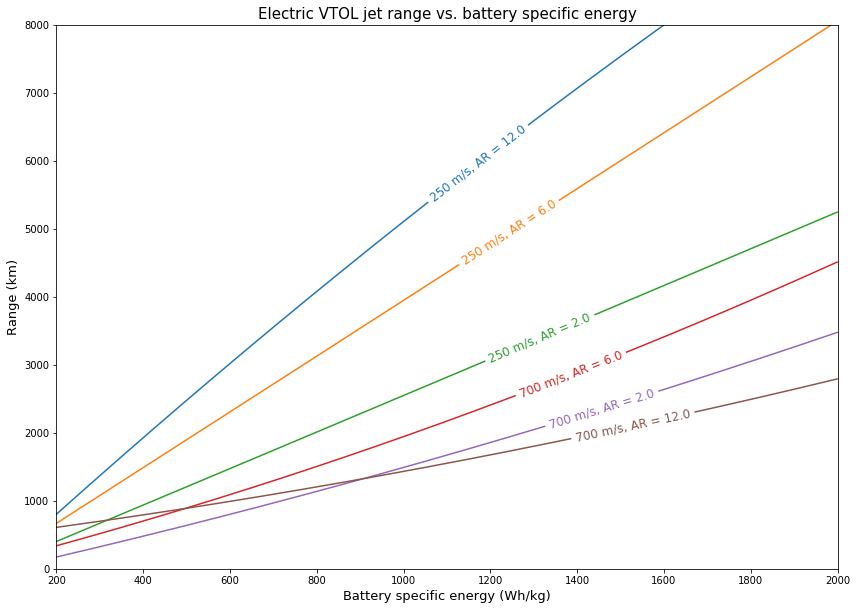

In [8]:
plt.figure(figsize=(14, 10))
plt.title('Electric VTOL jet range vs. battery specific energy', fontsize=15)
plt.ylabel('Range (km)', fontsize=13)
plt.xlabel('Battery specific energy (Wh/kg)', fontsize=13)
plt.xlim(200, 2000)
plt.ylim(0, 8000)

plot_specific_densities = np.arange(200, 2000)

for configuration in configurations:
    cruise_airspeed = configuration['cruise_airspeed']
    aspect_ratio = configuration['aspect_ratio']
    batteries = configuration['battery_specific_energy']

    distances = [plane_samples[(b, cruise_airspeed, aspect_ratio)]['total_distance'] / 1000 for b in batteries]

    c, b, a = np.polyfit(batteries, distances, deg=2)
    reg_range = a + b * plot_specific_densities + c * plot_specific_densities ** 2

    plt.plot(
        plot_specific_densities, reg_range,
        label=f"{cruise_airspeed} m/s, AR = {aspect_ratio}",
    )

labelLines(plt.gca().get_lines(), xvals=(1100, 1600), fontsize=12)

As expected, we find lower airspeeds and higher aspect ratios lead to better results. With current batteries, which are around 300 Wh/kg, we can achieve around a 1400 km range under our assumptions with a low airspeed, high aspect ratio aircraft.

The lower range of the 700 m/s aircraft with an aspect ratio of 12 shows that increasing aspect ratio only helps up to a point in supersonic flight. [This answer](https://aviation.stackexchange.com/questions/36761/why-does-the-aspect-ratio-of-a-wing-become-less-important-at-supersonic-speeds) gives an overview of why that is the case. In supersonic flight, the large aspect ratio wing has a higher range for lower battery specific energies because in this case the aircraft spends less time in cruise, and more time in subsonic ascent/descent where having a high aspect ratio wing is helpful.

It is clear that subsonic (250 m/s) electric aircraft will be viable before supersonic (700 m/s) electric aircraft. Supersonic VTOL electric aircraft may become viable somewhere around a battery specific energy of 1500 Wh/kg.

Raw aircraft data:

In [9]:
(
    pd.DataFrame(plane_samples.values(), index=plane_samples.keys())
    .reset_index()
    .rename(columns={'level_0': 'battery_specific_energy', 'level_1': 'airspeed', 'level_2': 'aspect_ratio'})
    .set_index(['battery_specific_energy', 'airspeed', 'aspect_ratio'])
)

,,,aircraft_length,battery_energy_remaining,battery_mass,climb_airspeed,climb_duration,climb_ending_altitude,climb_ending_distance,climb_power,cruise_duration,cruise_ending_altitude,cruise_ending_distance,cruise_power,descent_airspeed,descent_duration,descent_end_altitude_rel,descent_ending_altitude,descent_power,flight_energy_frac,loss,min_altitude_rel,reserve_airspeed,reserve_altitude_rel,reserve_ending_altitude,reserve_ending_distance,reserve_power,sweep_angle,total_distance,wing_area,wingspan
battery_specific_energy,airspeed,aspect_ratio,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
200,250,12.0,21.551184,2.142885e-07,48682.411079,134.297182,1197.451507,15000.298113,152366.158357,1.454010e+07,1971.483118,15000.012916,6.438792e+05,7.586958e+06,192.900830,1191.032295,146.709192,7385.459579,3.491761e+02,0.999981,-7.690314e+11,7.326053,70.769708,9.409761e-05,450.042344,1.073685e+06,1.715637e+02,0.523202,8.769443e+05,399.978968,60.012176
400,250,12.0,21.563016,4.804073e-06,50527.068277,136.079867,1196.773184,15000.007241,154408.070183,1.513885e+07,6148.465252,15001.234958,1.688475e+06,7.966515e+06,191.986476,1196.156859,149.719400,7535.970017,3.148705e+02,0.999991,-3.688224e+12,7.347408,72.357622,5.948009e-04,450.267660,2.121473e+06,2.914363e+02,0.523562,1.920475e+06,399.984337,60.000108
600,250,12.0,21.563213,4.707201e-07,51815.656252,138.571984,1189.570352,15000.972749,157262.015563,1.560134e+07,10320.719350,15000.222655,2.733904e+06,8.184702e+06,191.100091,1193.881159,151.721817,7636.090826,6.471690e+02,0.999994,-8.790452e+12,7.323282,73.850696,2.566333e-03,451.154850,3.169872e+06,5.984925e+02,0.523579,2.964870e+06,399.970787,59.998492
800,250,12.0,21.557520,5.311135e-06,51925.699925,140.500293,1183.749808,15000.290793,159470.102011,1.570222e+07,14491.963037,15000.745342,3.778670e+06,8.209618e+06,191.125696,1188.071906,151.902844,7645.142197,4.380534e+03,0.999995,-1.607742e+13,7.268861,73.715865,7.531302e-04,450.338909,4.214304e+06,6.686136e+02,0.523386,4.009666e+06,399.992204,60.006789
1000,250,12.0,21.560352,7.832122e-06,51952.469108,136.548193,1182.478485,15000.410255,154944.388863,1.557482e+07,18700.889382,15000.134534,4.824026e+06,8.217703e+06,191.088606,1186.382013,151.905640,7645.282011,2.664236e+03,0.999996,-2.555280e+13,7.390379,73.814520,5.445675e-03,452.450554,5.259882e+06,1.579703e+03,0.523472,5.054978e+06,399.993218,60.003872
1300,250,12.0,21.563421,3.892307e-07,52629.031256,138.333226,1178.799209,15000.010925,156988.690659,1.583257e+07,24975.793200,15000.443622,6.393624e+06,8.326073e+06,190.393847,1194.943168,153.041411,7702.070534,9.963302e+02,0.999997,-4.387426e+13,7.362315,74.485378,4.853473e-06,450.002184,6.830458e+06,4.687005e+02,0.523566,6.623765e+06,399.994191,60.000698
1600,250,12.0,21.556702,4.835372e-06,52907.600112,139.490228,1180.488207,15000.633759,158313.525909,1.595507e+07,31238.879870,15000.232604,7.962483e+06,8.371014e+06,190.377097,1198.665668,153.336011,7716.800526,6.490366e+03,0.999998,-6.711878e+13,7.338683,74.333542,1.403066e-03,450.631380,8.398887e+06,3.777457e+03,0.523358,8.192605e+06,399.995597,60.008015
2000,250,12.0,21.553486,2.446656e-06,58437.200953,286.505432,1194.118796,15005.397183,326198.019958,3.589226e+07,35992.590916,15004.643107,9.327271e+06,9.284876e+06,283.752854,1189.799713,161.163188,8108.159376,8.688509e+06,0.999998,-9.344488e+13,2.124307,78.909379,2.083037e-03,450.937366,9.888122e+06,3.510764e+04,0.523260,9.666689e+06,399.993895,60.011269
200,250,6.0,18.175305,1.164178e-07,34547.697868,125.960031,1176.245281,15020.952035,142810.459748,1.084324e+07,1335.701644,15042.464953,4.690730e+05,6.922738e+06,165.087835,1190.349157,142.472822,7173.641094,5.540572e+03,0.999981,-4.483180e+11,7.272244,67.866197,9.695985e-04,450.436319,8.576342e+05,3.387359e+05,0.520619,6.695656e+05,399.968889,42.497554
